# 1D CNN Segmentation Iberdrola Project - Phase 1

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
1.10.1+cu102


c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\cuda\__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3080 Ti Laptop GPU with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3080 Ti Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))

2.6.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Libraries

In [3]:
import os
import h5py
import scipy
import random
import pickle
import json
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr

In [4]:
from models import *
from models.unet_variants import *
# from models.saunet_variants import *

In [5]:
%matplotlib inline
sns.set_style('white')

# Import and Prepare Data

Import dataset

In [74]:
fl_Data = h5py.File(os.path.join('Data/Phase_2_Exp_1/05_Entertainment_Data_Matched_Occupancy.mat'), 'r')
fl_Data.keys()

<KeysViewHDF5 ['data_appliance', 'data_occupancy', 'house_number_array']>

Prepare Dataset for Training

In [75]:
X_Data = np.array(fl_Data['data_appliance'])
Y_Data = np.array(fl_Data['data_occupancy'])
house_data = np.array(fl_Data['house_number_array'])
print(X_Data.shape)
print(Y_Data.shape)
print(house_data.shape)

(189, 21600)
(189, 21600)
(1, 189)


In [76]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size=0.2, random_state=42)
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)

(151, 21600)
(151, 21600)
(38, 21600)
(38, 21600)


Overlap Train Set

In [77]:
# Overlap
X_Train_Shape = X_Train.shape
Y_Train_Shape = Y_Train.shape
segment_length = X_Train_Shape[1]
print(X_Train_Shape)
print(Y_Train_Shape)
# Reshape Array
X_Train_Reshaped = np.reshape(X_Train, (X_Train_Shape[0]*X_Train_Shape[1], 1))
Y_Train_Reshaped = np.reshape(Y_Train, (Y_Train_Shape[0]*Y_Train_Shape[1], 1))
X_Train_Reshaped_Shape = X_Train_Reshaped.shape
Y_Train_Reshaped_Shape = Y_Train_Reshaped.shape
print(X_Train_Reshaped_Shape)
print(Y_Train_Reshaped_Shape)
# Overlap
overlap_ratio = 0.9
offset_amount = np.int_(segment_length*(1 - overlap_ratio))
X_Train_New = np.zeros((10000,segment_length,1))
Y_Train_New = np.zeros((10000,segment_length,1))
num_segments_approx = np.int_(np.ceil(X_Train_Reshaped_Shape[0]/offset_amount))
counter = 0
for i in range(0,num_segments_approx):
    if (i*offset_amount+segment_length) > X_Train_Reshaped_Shape[0]:
        continue
    X_Train_Temp = X_Train_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    X_Train_New[counter,:,:] = X_Train_Temp
    Y_Train_Temp = Y_Train_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    Y_Train_New[counter,:,:] = Y_Train_Temp
    # print(X_Train_Temp.shape)
    counter = counter + 1
X_Train = X_Train_New[0:counter,:,:]
Y_Train = Y_Train_New[0:counter,:,:]
print(X_Train.shape)
print(Y_Train.shape)

(151, 21600)
(151, 21600)
(3261600, 1)
(3261600, 1)
(1501, 21600, 1)
(1501, 21600, 1)


Reshape Train Set

In [78]:
X_Train_shape = X_Train.shape
X_Train_CML = np.reshape(X_Train,(X_Train_shape[0]*X_Train_shape[1],1))
Y_Train_shape = X_Train.shape
Y_Train_CML = np.reshape(Y_Train,(Y_Train_shape[0]*Y_Train_shape[1],1))
X_Test_shape = X_Test.shape
X_Test_CML = np.reshape(X_Test,(X_Test_shape[0]*X_Test_shape[1],1))
Y_Test_shape = X_Test.shape
Y_Test_CML = np.reshape(Y_Test,(Y_Test_shape[0]*Y_Test_shape[1],1))
#
print(X_Train_CML.shape)
print(Y_Train_CML.shape)
print(X_Test_CML.shape)
print(Y_Test_CML.shape)

(32421600, 1)
(32421600, 1)
(820800, 1)
(820800, 1)


## AdaBoost

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

In [46]:
target_names = ['Non-occupied', 'Occupied']
clf = AdaBoostClassifier(n_estimators=1000, algorithm="SAMME", random_state=0)
clf.fit(X_Train_CML, Y_Train_CML)
Y_Pred_CML = clf.predict(X_Test_CML)
print(clf.score(Y_Test_CML, Y_Pred_CML))
print(classification_report(Y_Test_CML, Y_Pred_CML, target_names=target_names))

c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


1.0


c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

Non-occupied       0.00      0.00      0.00    177325
    Occupied       0.78      1.00      0.88    643475

    accuracy                           0.78    820800
   macro avg       0.39      0.50      0.44    820800
weighted avg       0.61      0.78      0.69    820800



c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_Train_CML, Y_Train_CML)
Y_Pred_CML = clf.predict(X_Test_CML)
print(clf.score(Y_Test_CML, Y_Pred_CML))
print(classification_report(Y_Test_CML, Y_Pred_CML, target_names=target_names))

0.9855872319688109
              precision    recall  f1-score   support

Non-occupied       0.01      0.00      0.00    177325
    Occupied       0.78      0.98      0.87    643475

    accuracy                           0.77    820800
   macro avg       0.40      0.49      0.44    820800
weighted avg       0.62      0.77      0.68    820800



In [80]:
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_Train_CML, Y_Train_CML)
Y_Pred_CML = clf.predict(X_Test_CML)
print(clf.score(Y_Test_CML, Y_Pred_CML))
print(classification_report(Y_Test_CML, Y_Pred_CML, target_names=target_names))

0.9855872319688109
              precision    recall  f1-score   support

Non-occupied       0.01      0.00      0.00    177325
    Occupied       0.78      0.98      0.87    643475

    accuracy                           0.77    820800
   macro avg       0.40      0.49      0.44    820800
weighted avg       0.62      0.77      0.68    820800



In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_Train_CML, Y_Train_CML)
Y_Pred_CML = clf.predict(X_Test_CML)
print(clf.score(Y_Test_CML, Y_Pred_CML))
print(classification_report(Y_Test_CML, Y_Pred_CML, target_names=target_names))

## XgBoost


## Reshape and Plot

In [83]:
Y_Pred = np.reshape(Y_Pred_CML,(Y_Test_shape[0],Y_Test_shape[1]))
print(Y_Pred.shape)

(38, 21600)


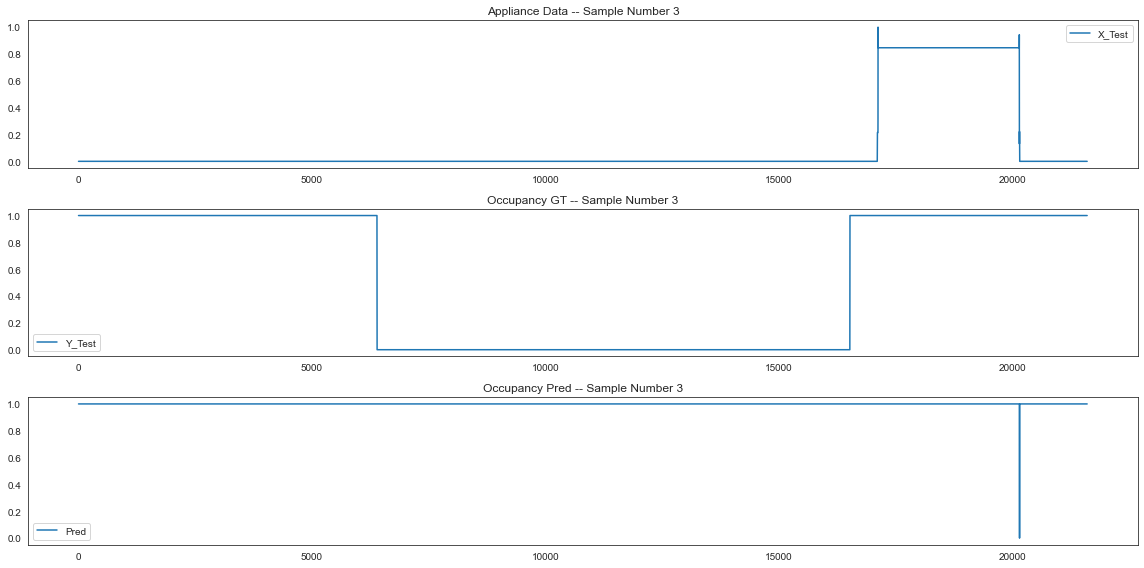

In [93]:
train_data_shape = Y_Test.shape
j = random.randint(0, train_data_shape[0])
A = X_Test[j,:]
B = Y_Test[j,:]
C = Y_Pred[j,:]
plt.figure(figsize=(16, 8))
plt.subplot(3, 1, 1)
plt.plot(A, label='X_Test')
plt.title(f"Appliance Data -- Sample Number {j}")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(B, label='Y_Test')
plt.title(f"Occupancy GT -- Sample Number {j}")
plt.tight_layout()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(C, label='Pred')
plt.title(f"Occupancy Pred -- Sample Number {j}")
plt.tight_layout()
plt.legend()

In [20]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Train
Checkpoint['Y'] = Y_Train
RawDataPath = 'Train_Set.pt'
torch.save(Checkpoint, RawDataPath)

In [21]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Val
Checkpoint['Y'] = Y_Val
RawDataPath = 'Val_Set.pt'
torch.save(Checkpoint, RawDataPath)

In [22]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Test
Checkpoint['Y'] = Y_Test
RawDataPath = 'Test_Set.pt'
torch.save(Checkpoint, RawDataPath)

### Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

In [96]:
document = (2000, 'bb', (101, 132, 345), ['sing','quizz'])
document[-1].append('poetry')
print(document)

(2000, 'bb', (101, 132, 345), ['sing', 'quizz', 'poetry'])


In [98]:
p = [1,1,2]
x = list(map(lambda x: x**2, L))
print(x)

NameError: name 'L' is not defined

# MAIN

## Configurations

In [23]:
# Configurations
signal_length = 21600  # Length of each Segment
problem_type = 'Regression'
lr = 5e-4

## Helper Functions

In [25]:
def Construction_Error(GRND, Pred):
    mae_construction_err = []
    mse_construction_err = []
    rmse_construction_err = []
    cc = []
    r2c = []
    bad_indices = []
    count = 0

    for i in range(len(GRND)):

        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        MSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=True)
        RMSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=False)

        if ~(np.std(Pred[i].ravel()) == 0 or np.std(GRND[i].ravel()) == 0):
            corr, _ = pearsonr(Pred[i].ravel(), GRND[i].ravel())
            r2_scr = r2_score(Pred[i].ravel(), GRND[i].ravel())
        else:
            continue

        if MAE < 1:
            mae_construction_err.append(MAE)
            mse_construction_err.append(MSE)
            rmse_construction_err.append(RMSE)
            cc.append(corr)
            r2c.append(r2_scr)
        elif MAE >= 1:
            count = count + 1
            bad_indices.append(i)

    print(f'MAE Construction Error: {round(np.mean(mae_construction_err), 3)} +/- {round(np.std(mae_construction_err), 3)}')
    print(f'MSE Construction Error: {round(np.mean(mse_construction_err), 3)} +/- {round(np.std(mse_construction_err), 3)}')
    print(f'RMSE Construction Error: {round(np.mean(rmse_construction_err), 3)} +/- {round(np.std(rmse_construction_err), 3)}')
    print(f'Pearson Correlation: {round(np.mean(cc)*100, 3)}% +/- {round(np.std(cc)*100, 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')
    print(f'Number of Bad Predictions = {count}')

In [26]:
def Construction_Error_Denorm(GRND, Pred):
    mae_construction_err = []
    mse_construction_err = []
    rmse_construction_err = []
    cc = []
    r2c = []
    count = 0

    for i in range(len(GRND)):

        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        MSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=True)
        RMSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=False)

        if ~(np.std(Pred[i].ravel()) == 0 or np.std(GRND[i].ravel()) == 0):
            corr, _ = pearsonr(Pred[i].ravel(), GRND[i].ravel())
            r2_scr = r2_score(Pred[i].ravel(), GRND[i].ravel())
        else:
            continue

        mae_construction_err.append(MAE)
        mse_construction_err.append(MSE)
        rmse_construction_err.append(RMSE)
        cc.append(corr)
        r2c.append(r2_scr)

    print(f'MAE Construction Error: {round(np.mean(mae_construction_err), 3)} +/- {round(np.std(mae_construction_err), 3)}')
    print(f'MSE Construction Error: {round(np.mean(mse_construction_err), 3)} +/- {round(np.std(mse_construction_err), 3)}')
    print(f'RMSE Construction Error: {round(np.mean(rmse_construction_err), 3)} +/- {round(np.std(rmse_construction_err), 3)}')
    print(f'Pearson Correlation: {round(np.mean(cc)*100, 3)}% +/- {round(np.std(cc)*100, 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')

## Train and Test

In [ ]:
# Load Data
Train_Data = torch.load('Train_Set.pt')
Test_Data = torch.load('Test_Set.pt')
Val_Data = torch.load('Train_Set.pt')
X_Train = Train_Data['X']
Y_Train = Train_Data['Y']
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
X_Val = Val_Data['X']
Y_Val = Val_Data['Y']






In [ ]:
# Load Resuts with Ground Truth and Inputs
fl_Data = h5py.File(os.path.join('Outcomes/UNet_4_64_DS_Microwave_SM3_21600.h5'),'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
# Y_Test_Denorm = fl_Data['App_Denorm']
# Y_Pred_Denorm = fl_Data['App_Pred_Denorm']

In [11]:
# Load Test Set and Print Shape
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
print(X_Test.shape)
print(Y_Test.shape)
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/UNet4P_Ch1_F1_P2_Air_Exhaust.h5'), 'r')
print(fl_Data.keys())
Y_Pred = np.array(fl_Data['App_Pred'])
# Y_Pred[Y_Pred >= 0.5] = 1
# Y_Pred[Y_Pred < 0.5] = 0

(38, 21600, 1)
(38, 21600, 1)
<KeysViewHDF5 ['App', 'App_Pred', 'SM']>


In [ ]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(X_Test[i,:,0], label='GT')
# plt.ylim(0,1)
plt.title(f"Appliance Load Consumption -- Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,2)
plt.plot(Y_Test[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Occupancy GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,3)
plt.plot(Y_Pred[i,:,0], label='Pred')
# plt.ylim(0,1)
plt.title(f"Occupancy Estimated", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

In [ ]:
Construction_Error(Y_Test, Y_Pred)

In [18]:
# Save Outcomes
print('Saving Results')
File = h5py.File(f'Outcomes/UNet4P_5_32_DS_Microwave_SM3_21600_Overlapped.h5', 'w')
File.create_dataset('SM', data=X_Test)
File.create_dataset('App', data=Y_Test)
File.create_dataset('App_Pred', data=Y_Pred)
File.create_dataset('App_Denorm', data=Y_Test_Denorm)
File.create_dataset('App_Pred_Denorm', data=Y_Pred_Denorm)
File.close()

Saving Results


In [ ]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/UNet4P_5_32_DS_Microwave_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']

# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass